# Cleaning, Reshaping and Plotting Data with Python

This is a [Jupyter](http://jupyter.org/) notebook that shows how to use Python and Pandas to clean up a slightly dirty dataset for analysis. We'll also look at using [matplotlib](https://matplotlib.org/) for exploratory charting to help us understand and find stories in the data.

We hope to cover:

* Cleaning data
    * Renaming columns
    * Removing rows and columns
    * Merging header columns that span multiple rows
    * Converting the type of variables in a dataset
    * Finding and fixing bad values
* Exploratory visualization
    * [Using Pandas with matplotlib](https://pandas.pydata.org/pandas-docs/stable/visualization.html) to make simple plots
    
## Keep this in mind

One of the hardest things that I found when learning Pandas was that there are many ways of doing similar things. The *best* way often depends on exactly what you are trying to do and how important performance is. I'll show multiple methods of doing things where it feels absolutely neccessary, but for brevity and clarity, I'm going to try to stick to one method. There are other ways of doing these things that might be better for a particular situaton.

## Python stuff we'll use

You will get the most out of this session if you have some familiarity with Python programming and the basics of working with Pandas. There are a few Python concepts that you'll see in the code. You don't have to have extensive experience using them, but it will help if you know that they exist and how to spot them in the code.

* Defining functions in Python.
* "keyword" and "positional" arguments of functions.
* [List comprehensions](http://www.pythonforbeginners.com/basics/list-comprehensions-in-python) and [dict comprehensions](https://www.python.org/dev/peps/pep-0274/)
* [Regular expressions](https://docs.python.org/3/howto/regex.html)
* [`str.format()`](https://pyformat.info/)
* `try`/`except` and [exception handling](https://docs.python.org/3/tutorial/errors.html)

## Pandas stuff we'll use

Having a working understanding of these concepts will help you get the most out of this activity. If you don't know some of this stuff, that's fine, but you might want to revisit these concepts later.

* The `DataFrame` and `Series` data structures and understanding the relationship between the two. The [Intro to Data Structures](https://pandas.pydata.org/pandas-docs/stable/dsintro.html) section of the pandas documentation is a good place to look if you need a refresher.
* Understanding what the concept of an Index of a `DataFrame` or `Series`.
* Understanding that many `DataFrame` methods return a new `DataFrame`
* Accessing `DataFrame` values with [`at`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.at.html#pandas.DataFrame.at), [`loc`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html#pandas.DataFrame.loc), [`iat`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.iat.html#pandas.DataFrame.iat) and [`iloc`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.iloc.html#pandas.DataFrame.iloc). The best starting place for this is probably the [Indexing and Selecting Data](https://pandas.pydata.org/pandas-docs/stable/indexing.html) section of the Pandas docs.
* Showing only a few rows of a `DataFrame` using [`DataFrame.head`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html)


## Conventions in this notebook

* `EDIT THIS` - This indicates sections of Python code in notebook cells that you'll want to edit to try out concepts that we're talking about.
* `CAN'T TOUCH THIS` - These are sections of Python code in notebook cells that you should leave alone as you work through this exercise.
* ⬇️ - There are places in this notebook where you'll be asked a question about the data, or be asked to use a concept you're learning to update some code to make it work. A working solution will follow, but I've added a bunch of whitespace so it's hidden from view. The downward arrow symbol (⬇️) reminds you to scroll down to see the solution and the rest of the exercise.

## About the data

The data we're working with in this session is a Monthly Central Bond Court Disposition Audit report from the Cook County Criminal Court. These reports are sometimes also referred to as "monthly disposition statistcs reports" or "star reports". They are sent to the Office of the President of the Cook County Board of Commissioners by either the Office of the Cook County Clerk of the Circuit Court or the Office of the Chief Judge.

This data was recently [shared](https://gitlab.com/ChicagoDataCooperative/bond-court-dispositions) by the [Chicago Data Collaborative](https://chicagodatacollaborative.org/).

## Notebook boilerplate

There are a few things that you'll do when you initialize a Jupyter notebook to work with Pandas. This includes importing pandas and specifying how we'll display plots in our notebook. Many of your data cleaning and visualization notebooks or programs will will start out this way.

In [1]:
# Specify how `matplotlib` will display plots in this notebook.
# `notebook` will create interactive charts.
# `inline` will create static images.
%matplotlib notebook
#%matplotlib inline

# It's conventional to import pandas as `pd`
import pandas as pd

# This is the conventional way to import the matplotlib API
import matplotlib.pyplot as plt

# We'll explicitly display dataframes inline in our notebook
from IPython.display import display

# The `os.path` module that comes as part of Python's standard library helps us build pathnames.
# We'll use this to build variables that point to our data.
import os

# Data cleaning will almost surely use regular expressions at some point
import re

This is some code we'll use throughout the notebook to make it easier to use as a learning tool. You probably won't need to do this in your own notebooks.

In [2]:
from IPython.utils.coloransi import TermColors as tc

def print_red(s):
    print(tc.Red + s + tc.Normal)
    
def print_green(s):
    print(tc.Green + s + tc.Normal)

## Data cleaning

### Take a peek at the data

Let's load some data to identify some potential issues with the data.

In [3]:
# Create some variables to point to our data
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data')

# Define a helper function to get the path to a particular month's CSV file.
def get_monthly_data_path(month):
    """Returns a path to a month's CSV file"""
    return os.path.join(DATA_PATH, 'CBC_{}_2017_Disposition_Stats.csv'.format(month))


In [4]:
data_path = get_monthly_data_path('January')

# I like to store the data that is loaded without any additional transformations in a `_raw` variable.
# This lets me try different transforms and throw them away if they don't work without having to
# reload the data.
data_january_raw = pd.read_csv(data_path)

display(data_january_raw)

,Jan-17,103,606,604,605,277,601,153,TOTAL CASES,894,278,279,RELS'D ON,RELS'D ON D
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C BOND,BOND
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32
5,1/5/2017,0.0,8.0,0.0,24.0,7.0,53,0.0,92,0.0,0.0,0,0,46
6,1/6/2017,0.0,10.0,0.0,20.0,9.0,43,0.0,82,0.0,0.0,0,0,33
7,1/7/2017,0.0,7.0,4.0,39.0,18.0,53,0.0,121,0.0,0.0,0,0,56
8,1/8/2017,0.0,2.0,0.0,24.0,26.0,78,1.0,131,0.0,0.0,0,1,72
9,1/9/2017,2.0,6.0,0.0,26.0,11.0,38,0.0,83,0.0,22.0,20,1,73


### What's wrong with the data?


What things might be problematic about this data? Think about it and then scroll down to see the answers.

⬇️

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

* Column name of first column reflects the month of the data. Why is this a problem?
* Codes in column names
* Headers in columns 13 and 14 split across rows
* Malformed date for first row of data
* `TOTALS` row that doesn't exactly represent the same time unit as the other rows
* A value of `q0` in the `278` column

To better understand how this dirtyness occurred, it might be helpful to understand what happened before we loaded this data into Pandas. This data originally came as a PDF file, that was converted to CSV using [Tabula](http://tabula.technology/).

Here's what the January data looks like:

![January data as a PDF](img/screenshot__january_data.png)

As you can see, the data issues are due to a combination of factors:

* data designed for humans to read, not computers
* human error when entering data
* issues introduced when converting the data from PDF

Regardless of the cause, we'll try to clean up the data and address the issues we identified earlier one by one as we move forward.

### Renaming columns

Let's rename the first column in a way that might let us more easily combine the monthly data into one dataset.

We can use the [`pandas.DataFrame.rename`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html) method to do this.

We're specifying our renaming mapping by passing a `dict` where the keys are the old column names and the values are the new column names.

We specify that we're renaming columns of the spreadsheet rather than rows by specifying the `columns` keyword argument. `DataFrame.rename` can also be used to rename index entries.

In [5]:
data_january = data_january_raw.rename(columns={'Jan-17': 'date'})
display(data_january.head())

,date,103,606,604,605,277,601,153,TOTAL CASES,894,278,279,RELS'D ON,RELS'D ON D
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C BOND,BOND
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32


We can also rename the columns by assigning a new list of columns to the `DataFrame.columns` attribute. This isn't the ideal way to do it, because it's less clear what your code is doing than with using `rename`, but there are some cases where it's useful, and easier.

In [6]:
# Get the existing column names
col_names = data_january_raw.columns.values.tolist()
# This also works, but the above method is the more performant method:
# col_names = list(data_january_raw)

# Change the first column name
col_names[0] = 'date'

# Make a copy of the original dataframe
data_january = data_january_raw.copy()

# Set the column names of the new dataframe to our modified names
data_january.columns = col_names

display(data_january.head())

,date,103,606,604,605,277,601,153,TOTAL CASES,894,278,279,RELS'D ON,RELS'D ON D
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C BOND,BOND
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32


### Renaming columns: you try it

The columns in the source data use codes, which don't mean a whole lot to us. Luckily, the souce PDFs define a lookup table to titles that are easier to understand. We can easily make a Python dictionary out of it.

In [7]:
CODE_LOOKUP = {
    '103': "Nolle Pros",
    '606': "No Bail",
    '604': "Bond to Stand",
    '605': "I-Bonds",
    '277': "EMI",
    '601': "D-Bonds",
    '153': "C-Bonds",
    '894': "Electronic Monitor",
    '278': "Admit to Sheriff EM Prg",
    '279': "Not Admitted to EM Prg",
}

# EDIT THIS: Uncomment the line below and update it to so it converts the columns with codes to 
# human-readable names.

# data_january = data_january.

# CAN'T TOUCH THIS! The code below tests your solution.
def test_header_codes_renamed(df, lookup):
    for old_col_name, new_col_name in lookup.items():
        # Oh hey! You can test if a column exists in a dataframe similar to how you'd
        # check if a key is in a dictionary!
        assert new_col_name in df
        
try:
    test_header_codes_renamed(data_january, CODE_LOOKUP)
except AssertionError:
    print_red("\n⚠️ Oops! It looks like you didn't rename at least one of the columns correctly.\n")
else:
    print_green("\n👍 You got it!\n")

display(data_january.head())


⚠️ Oops! It looks like you didn't rename at least one of the columns correctly.



,date,103,606,604,605,277,601,153,TOTAL CASES,894,278,279,RELS'D ON,RELS'D ON D
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C BOND,BOND
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32


If you weren't able to figure it out, here's the solution. Make sure you run this cell to get your data in the right shape for the rest of the excercise.

In [8]:
data_january = data_january.rename(columns=CODE_LOOKUP)
display(data_january.head())

,date,Nolle Pros,No Bail,Bond to Stand,I-Bonds,EMI,D-Bonds,C-Bonds,TOTAL CASES,Electronic Monitor,Admit to Sheriff EM Prg,Not Admitted to EM Prg,RELS'D ON,RELS'D ON D
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C BOND,BOND
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32


### Renaming columns: Merging column names that span multiple rows

The first row of the data still contains the additional part of the column name for the latter columns. Let's merge the first two rows together.  The pseudocode for this operation goes something like this:

* Loop through the column names
* For each column name, check if there's a value in the first row
* If there isn't a value, do nothing
* If there is a value, add it to the existing column name

We'll use [`pandas.isnull`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.isnull.html) to check whether there's a value in each column of the first row.

For this particular case, it seems easier to update the columns by assigning a new value to `DataFrame.columns` instead of using `DataFrame.rename`.

In [9]:
def merge_headers(df, col_name):
    first_row_val = df[col_name][0]
    if pd.isnull(first_row_val):
        return col_name
    
    return '{0} {1}'.format(col_name, first_row_val)

# Since we need to access the dataframe in our column name mapping function,
# can't really use `pandas.DataFrame.rename` because it just passes the column
# name to the mapper. We'll just modify the list of column names and then
# assign them to the `columns` attribute of our dataframe.

# Get the current column names
col_names = data_january.columns.values.tolist()

# Map the old names to new ones that merge two rows together.
# This is called a list comprehension
new_col_names = [merge_headers(data_january, c) for c in col_names]
data_january.columns = new_col_names

display(data_january.head())

,date,Nolle Pros,No Bail,Bond to Stand,I-Bonds,EMI,D-Bonds,C-Bonds,TOTAL CASES,Electronic Monitor,Admit to Sheriff EM Prg,Not Admitted to EM Prg,RELS'D ON C BOND,RELS'D ON D BOND
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C BOND,BOND
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32


### Remove rows

We've merged the header rows together, but we still have the wonky first row of our dataset. Let's get rid of the first row with [`DataFrame.drop`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

In [10]:
data_january = data_january.drop(0)
display(data_january.head())

,date,Nolle Pros,No Bail,Bond to Stand,I-Bonds,EMI,D-Bonds,C-Bonds,TOTAL CASES,Electronic Monitor,Admit to Sheriff EM Prg,Not Admitted to EM Prg,RELS'D ON C BOND,RELS'D ON D BOND
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32
5,1/5/2017,0.0,8.0,0.0,24.0,7.0,53,0.0,92,0.0,0.0,0,0,46


### Renaming columns with a function

The column headings are now human-readable, but they still look ugly and might cause problems if we ever want to export the data and import it into another program. We can write a function that takes an existing column name as a n argument and returns a new column name. We can then pass this function to `DataFrame.rename`.

In [11]:
def slugify(s, replacement_char="_"):
    """Return version of string that can be used as column name, property or dictionary key"""
    slugified = s
    slugified = re.sub(r'[\s\-]+', replacement_char, slugified)
    slugified = slugified.lower()
    return slugified
    
data_january = data_january.rename(columns=slugify)

print(data_january.columns)

Index(['date', 'nolle_pros', 'no_bail', 'bond_to_stand', 'i_bonds', 'emi',
       'd_bonds', 'c_bonds', 'total_cases', 'electronic_monitor',
       'admit_to_sheriff_em_prg', 'not_admitted_to_em_prg', 'rels'd_on_c_bond',
       'rels'd_on_d_bond'],
      dtype='object')


### Renaming columns with a function: you try it

Things are looking better, but we forgot to deal with the apostrophe in the latter column names. Update the slugify function to remove apostrophes (`'`) and make our `data_january` `DataFrame` have really clean column names.

In [12]:
def slugify(s, replacement_char="_"):
    """Return version of string that can be used as column name, property or dictionary key"""
    slugified = s
    # EDIT THIS! Modify this function so that it removes apostrophes.
    slugified = re.sub(r'[\s\-]+', replacement_char, slugified)
    slugified = slugified.lower()
    return slugified

# EDIT THIS! Add a line below to use your `slugify` function to rename the columns.



# CAN'T TOUCH THIS! The code below tests your solution.
def test_no_apostrophes(df):
    assert df.columns[-2] == 'relsd_on_c_bond'
    assert df.columns[-1] == 'relsd_on_d_bond'

    
try:
    test_no_apostrophes(data_january)
except AssertionError:
    print_red("\n⚠️ Oops! It looks like you didn't rename at least one of the columns correctly.\n")
else:
    print_green("\n👍 You got it!\n")
    
display(data_january.head())



⚠️ Oops! It looks like you didn't rename at least one of the columns correctly.



,date,nolle_pros,no_bail,bond_to_stand,i_bonds,emi,d_bonds,c_bonds,total_cases,electronic_monitor,admit_to_sheriff_em_prg,not_admitted_to_em_prg,rels'd_on_c_bond,rels'd_on_d_bond
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32
5,1/5/2017,0.0,8.0,0.0,24.0,7.0,53,0.0,92,0.0,0.0,0,0,46


If you weren't able to figure it out, here's the solution. Make sure you run this cell to get your data in the right shape for the rest of the excercise.

In [13]:
def slugify(s, replacement_char="_"):
    """Return version of string that can be used as column name, property or dictionary key"""
    slugified = s
    slugified = re.sub(r'[\s\-]+', replacement_char, slugified)
    slugified = slugified.replace("'", '')
    slugified = slugified.lower()
    return slugified

data_january = data_january.rename(columns=slugify)

display(data_january)

,date,nolle_pros,no_bail,bond_to_stand,i_bonds,emi,d_bonds,c_bonds,total_cases,electronic_monitor,admit_to_sheriff_em_prg,not_admitted_to_em_prg,relsd_on_c_bond,relsd_on_d_bond
1,011/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32
5,1/5/2017,0.0,8.0,0.0,24.0,7.0,53,0.0,92,0.0,0.0,0,0,46
6,1/6/2017,0.0,10.0,0.0,20.0,9.0,43,0.0,82,0.0,0.0,0,0,33
7,1/7/2017,0.0,7.0,4.0,39.0,18.0,53,0.0,121,0.0,0.0,0,0,56
8,1/8/2017,0.0,2.0,0.0,24.0,26.0,78,1.0,131,0.0,0.0,0,1,72
9,1/9/2017,2.0,6.0,0.0,26.0,11.0,38,0.0,83,0.0,22.0,20,1,73
10,1/10/2017,2.0,7.0,0.0,24.0,15.0,35,0.0,83,0.0,3.0,6,0,18


## Detecting a bad value

We can see the datatypes of the columns in a `DataFrame` by inspecting the `DataFrame.dtypes` attribute. When loading data, Pandas tries to convert the CSV values to sensible data types. However, if the types don't match our expectations, it might indicate that there are some bad values in our data.

One important thing to note.  The data types used by Pandas have non-obvious names. This table, which I lifted from  ["Data Types and Formats"](http://chris.friedline.net/2015-12-15-rutgers/lessons/python2/03-data-types-and-format.html) helps clear things up:

| Pandas Type | Native Python Type | Description |
| --- | --- | --- |
| object | string | The most general dtype. Will be assigned to your column if column has mixed types (numbers and strings).|
| int64 | int | Numeric characters. 64 refers to the memory allocated to hold this character. |
| float64 | float | Numeric characters with decimals. If a column contains numbers and NaNs(see below), pandas will default to float64, in case your missing value has a decimal. |
| datetime64, timedelta[ns]	| N/A (but see the datetime module in Python's standard library) | Values meant to hold time data. Look into these for time series experiments. |

In [14]:
data_january.dtypes

date                        object
nolle_pros                 float64
no_bail                    float64
bond_to_stand              float64
i_bonds                    float64
emi                        float64
d_bonds                     object
c_bonds                    float64
total_cases                 object
electronic_monitor         float64
admit_to_sheriff_em_prg    float64
not_admitted_to_em_prg      object
relsd_on_c_bond             object
relsd_on_d_bond             object
dtype: object

🤔 The date column seems like it should be `datetime64`, but it's not.  Let's try to convert it using [`pandas.to_datetime`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html)

### Converting date values

In [15]:
try:
    pd.to_datetime(data_january['date'])
except ValueError as e:
    msg = "Error converting values to dates: {0}".format(e)
    print(msg)

Error converting values to dates: Unknown string format


That didn't work. We can make `pandas.to_datetime` more forgiving by specifying the `errors` argument.

In [16]:
pd.to_datetime(data_january['date'], errors='coerce')

1    2017-11-01
2    2017-01-02
3    2017-01-03
4    2017-01-04
5    2017-01-05
6    2017-01-06
7    2017-01-07
8    2017-01-08
9    2017-01-09
10   2017-01-10
11   2017-01-11
12   2017-01-12
13   2017-01-13
14   2017-01-14
15   2017-01-15
16   2017-01-16
17   2017-01-17
18   2017-01-18
19   2017-01-19
20   2017-01-20
21   2017-01-21
22   2017-01-22
23   2017-01-23
24   2017-01-24
25   2017-01-25
26   2017-01-26
27   2017-01-27
28   2017-01-28
29   2017-01-29
30   2017-01-30
31   2017-01-31
32          NaT
Name: date, dtype: datetime64[ns]

It took the best guess at interpretting our wonky date string, but it didn't give us the correct value. We should be careful using `errors='coerce'`.

We can also ignore errors, which will avoid the code throwing an exception ...

In [17]:
pd.to_datetime(data_january['date'], errors='ignore')

1      011/2017
2      1/2/2017
3      1/3/2017
4      1/4/2017
5      1/5/2017
6      1/6/2017
7      1/7/2017
8      1/8/2017
9      1/9/2017
10    1/10/2017
11    1/11/2017
12    1/12/2017
13    1/13/2017
14    1/14/2017
15    1/15/2017
16    1/16/2017
17    1/17/2017
18    1/18/2017
19    1/19/2017
20    1/20/2017
21    1/21/2017
22    1/22/2017
23    1/23/2017
24    1/24/2017
25    1/25/2017
26    1/26/2017
27    1/27/2017
28    1/28/2017
29    1/29/2017
30    1/30/2017
31    1/31/2017
32       TOTALS
Name: date, dtype: object

But then none of the values get converted.

### Updating a value in-place

We need to fix our wonky value. One way we can do it is by accessing the value directly.

In [18]:
# Let's fix our original column
data_january.at[1, 'date'] = '1/1/2017'

display(data_january.head())

,date,nolle_pros,no_bail,bond_to_stand,i_bonds,emi,d_bonds,c_bonds,total_cases,electronic_monitor,admit_to_sheriff_em_prg,not_admitted_to_em_prg,relsd_on_c_bond,relsd_on_d_bond
1,1/1/2017,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,1/2/2017,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,1/3/2017,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,1/4/2017,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32
5,1/5/2017,0.0,8.0,0.0,24.0,7.0,53,0.0,92,0.0,0.0,0,0,46


### Updating values with a function

But what if we had multiple errors that still followed a predictable pattern? We might write a function that can fix the values.

In [19]:
def fix_bad_date(s):
    """
    Correct a malformed date string
    
    Fix a string containing a date in the  form M/DD/YYYY where the `/` between
    the month and day is missing.
    
    """
    bits = s.lstrip('0').split('/')
    if len(bits) == 2:
        bits = [bits[0][0], bits[0][1:], bits[1]]
    
    return '/'.join(bits)
    
print(fix_bad_date('011/2017'))

1/1/2017


To run the value on every value in a column, we use [`Series.apply`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html). Remember, a column of a `DataFrame` is a `Series`.

In [20]:
# Undo our previous fix
data_january.at[1, 'date'] = '011/2017'

# Now run it on the entire column
data_january['date'].apply(fix_bad_date)

1      1/1/2017
2      1/2/2017
3      1/3/2017
4      1/4/2017
5      1/5/2017
6      1/6/2017
7      1/7/2017
8      1/8/2017
9      1/9/2017
10    1/10/2017
11    1/11/2017
12    1/12/2017
13    1/13/2017
14    1/14/2017
15    1/15/2017
16    1/16/2017
17    1/17/2017
18    1/18/2017
19    1/19/2017
20    1/20/2017
21    1/21/2017
22    1/22/2017
23    1/23/2017
24    1/24/2017
25    1/25/2017
26    1/26/2017
27    1/27/2017
28    1/28/2017
29    1/29/2017
30    1/30/2017
31    1/31/2017
32       TOTALS
Name: date, dtype: object

`Series.apply` returns a copy of the series with the function applied. If we want to modify our `DataFrame` we need to assign the result of `Series.apply` back to the column.

In [21]:
# Apply our transformation and assign the result back to the column
data_january['date'] = data_january['date'].apply(fix_bad_date)

# Now that we've fixed the bad value we should be able to convert our column to a date type, right?
data_january['date'] = pd.to_datetime(data_january['date'], errors='ignore')

print(data_january.dtypes)

date                        object
nolle_pros                 float64
no_bail                    float64
bond_to_stand              float64
i_bonds                    float64
emi                        float64
d_bonds                     object
c_bonds                    float64
total_cases                 object
electronic_monitor         float64
admit_to_sheriff_em_prg    float64
not_admitted_to_em_prg      object
relsd_on_c_bond             object
relsd_on_d_bond             object
dtype: object


That doesn't seem right. The `date` column still has the type `object`.

What's wrong? Think about it and then scroll down for the answer.

⬇️


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

There's still a non-date value in the last row, `TOTALS`.

Can you filter it out and successfully convert the `date` column to a date type? This should be fine because we should be able to calculate the monthly totals ourselves. In a real-world situation, I might save the monthly totals from the source data in a separate frame to validate the other rows.

In [22]:
# EDIT THIS! Uncomment and update the line below to remove the `TOTALS` row from the `DataFrame`.

# data_january =

# EDIT THIS! Add a line of code that converts the `date` column to a date type

# CAN'T TOUCH THIS! 
def test_totals_removed(df):
    assert df['date'].iloc[-1] != 'TOTALS', "The `TOTALS` row was not removed."
    
def test_date_col_is_not_object(df):
    assert str(data_january.dtypes[0]) != 'object', "The `date` column still has a type of `object`"
    
try:
    test_totals_removed(data_january)
except AssertionError as e:
    print_red("\n⚠️ {0}\n".format(e))
else:
    print_green("\n👍 You removed the `TOTALS` row!\n")
    
try:
    test_date_col_is_not_object(data_january)
except AssertionError as e:
    print_red("\n⚠️ {0}\n".format(e))
else:
    print_green("\n👍 The `date` column has a date type. Nice work!\n")


⚠️ The `TOTALS` row was not removed.


⚠️ The `date` column still has a type of `object`



If you weren't able to figure it out, scroll down to see that solution. Make sure you run the cell below to get your data in the right shape for the rest of the excercise.

⬇️


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

Here's the solution:

In [23]:
data_january = data_january[data_january['date'] != 'TOTALS']
data_january['date'] = pd.to_datetime(data_january['date'])

display(data_january)

,date,nolle_pros,no_bail,bond_to_stand,i_bonds,emi,d_bonds,c_bonds,total_cases,electronic_monitor,admit_to_sheriff_em_prg,not_admitted_to_em_prg,relsd_on_c_bond,relsd_on_d_bond
1,2017-01-01,0.0,4.0,0.0,45.0,12.0,64,0.0,125,0.0,0.0,0,1,67
2,2017-01-02,0.0,4.0,0.0,37.0,9.0,68,3.0,121,0.0,0.0,0,3,63
3,2017-01-03,0.0,3.0,0.0,21.0,10.0,39,0.0,73,0.0,0.0,0,0,23
4,2017-01-04,0.0,6.0,0.0,27.0,20.0,41,0.0,94,0.0,1.0,2,0,32
5,2017-01-05,0.0,8.0,0.0,24.0,7.0,53,0.0,92,0.0,0.0,0,0,46
6,2017-01-06,0.0,10.0,0.0,20.0,9.0,43,0.0,82,0.0,0.0,0,0,33
7,2017-01-07,0.0,7.0,4.0,39.0,18.0,53,0.0,121,0.0,0.0,0,0,56
8,2017-01-08,0.0,2.0,0.0,24.0,26.0,78,1.0,131,0.0,0.0,0,1,72
9,2017-01-09,2.0,6.0,0.0,26.0,11.0,38,0.0,83,0.0,22.0,20,1,73
10,2017-01-10,2.0,7.0,0.0,24.0,15.0,35,0.0,83,0.0,3.0,6,0,18


### Updating values with `pandas.DataFrame.replace`

Pandas provides a Dataframe method, [`pandas.DataFrame.replace`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) which lets you replace a value throughout a DataFrame. Note that a Series has a similar method.

For example:

In [24]:
# Set up a simple DataFrame just for illustration purposes.
d = {'name': ['Jeff', 'Jethro', 'Jefferson']}
names_df = pd.DataFrame(d)
display(names_df)

# Now let's use `replace()` to change a value
print("\nReplaced: ")
display(names_df.replace('Jeff', 'Geoff'))

,name
0,Jeff
1,Jethro
2,Jefferson



Replaced: 


,name
0,Geoff
1,Jethro
2,Jefferson


You can also use a regular expression as the first argument to [`pandas.DataFrame.replace`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html):

In [25]:
# Set up a simple DataFrame just for illustration purposes.
d = {'day_of_week': ['Monday', 'Thur.', 'Thr.', 'Thur']}
days_df = pd.DataFrame(d)
display(days_df)

# Now let's use `replace` with a regex to change values.
print("\nReplaced: ")
thur_re = re.compile(r'Thu?r\.?')
display(days_df.replace(thur_re, 'Thursday'))

,day_of_week
0,Monday
1,Thur.
2,Thr.
3,Thur



Replaced: 


,day_of_week
0,Monday
1,Thursday
2,Thursday
3,Thursday


### Updating values with `pandas.DataFrame.replace`: you try it

Use [`pandas.DataFrame.replace`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) on our `data_january` `DataFrame` to fix the wonky `q0` value in the `not_admitted_to_em_prg` column.

In [26]:
try:
    # EDIT THIS: Update the line below to call to pandas.DataFrame.replace 
    # to change the "q0" value to "0".
    data_january = data_january.replace()
except TypeError:
    print_red("\n⚠️ It looks like you didn't call `replace()` correctly. Try again.\n")

    
# CAN'T TOUCH THIS!
def test_q0_fixed(df):
    assert data_january.iloc[27, 11] == "0", '"q0" value not correctly removed'

try:
    test_q0_fixed(data_january)
except AssertionError as e:
    print_red("\n⚠️ {0}\n".format(e))
else:
    print_green("\n👍 You removed the `TOTALS` row!\n")
    


⚠️ It looks like you didn't call `replace()` correctly. Try again.


⚠️ "q0" value not correctly removed



If you weren't able to figure it out, scroll down to see that solution. Make sure you run the cell below to get your data in the right shape for the rest of the excercise.

⬇️


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

Here's the solution:

In [27]:
data_january = data_january.replace('q0', '0')

### More type conversion methods

In addition to [`pandas.to_datetime`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html#pandas.to_datetime), Pandas also provides utility methods to do other type conversions:

* [`pandas.to_numeric`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_numeric.html) - Convert argument to a numeric type.
* [`pandas.to_timedelta`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_timedelta.html#pandas.to_timedelta) - Convert argument to timedelta.


In [28]:
pd.to_numeric(data_january['nolle_pros'], downcast='integer')

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     2
10    2
11    0
12    2
13    1
14    0
15    0
16    0
17    3
18    3
19    1
20    0
21    0
22    0
23    2
24    2
25    0
26    1
27    1
28    0
29    0
30    6
31    0
Name: nolle_pros, dtype: int8

Pandas also provides an `astype()` method for `DataFrame` and `Series` for type conversion. You can read the docs [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.astype.html).

You can convert just one column by calling `astype` on the column (which is a `Series`):

In [29]:
data_january['d_bonds'] = data_january['d_bonds'].astype('float64')

Or, you can pass a dictionary of column name to type mappings on the `DataFrame` object:

In [30]:
data_january = data_january.astype({
    'total_cases': 'float64',
    "relsd_on_c_bond": 'float64',
})
display(data_january.dtypes)

date                       datetime64[ns]
nolle_pros                        float64
no_bail                           float64
bond_to_stand                     float64
i_bonds                           float64
emi                               float64
d_bonds                           float64
c_bonds                           float64
total_cases                       float64
electronic_monitor                float64
admit_to_sheriff_em_prg           float64
not_admitted_to_em_prg             object
relsd_on_c_bond                   float64
relsd_on_d_bond                    object
dtype: object

### Using `pandas.DataFrame.astype` to change column types: you try it

Use `pandas.DataFrame.astype` to convert the remaining columns that have a type of `object` to have a type of `float64`.

In [31]:
try:
    # EDIT THIS: Edit the line below to call `pandas.DataFrame.astype` to convert the column types.
    data_january = data_january.astype()

except TypeError:
    print_red("\n⚠️ It looks like you didn't call `astype()` correctly. Try again.\n")
    
# CAN'T TOUCH THIS
def test_column_types(df):
    for col in list(df):
        if col != 'date':
            assert df[col].dtype == 'float64', "Column `{0}` isn't a float64.".format(col)

try:
    test_column_types(data_january)
except AssertionError as e:
    print_red("\n⚠️ {0}\n".format(e))
else:
    print_green("\n👍 You converted all the column types\n")    



⚠️ It looks like you didn't call `astype()` correctly. Try again.


⚠️ Column `not_admitted_to_em_prg` isn't a float64.



If you weren't able to figure it out, scroll down to see that solution. Make sure you run the cell below to get your data in the right shape for the rest of the excercise.

⬇️


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

Here's the solution:

In [32]:
data_january = data_january.astype({
    'not_admitted_to_em_prg': 'float64',
    "relsd_on_d_bond": 'float64',
})
display(data_january.dtypes)

date                       datetime64[ns]
nolle_pros                        float64
no_bail                           float64
bond_to_stand                     float64
i_bonds                           float64
emi                               float64
d_bonds                           float64
c_bonds                           float64
total_cases                       float64
electronic_monitor                float64
admit_to_sheriff_em_prg           float64
not_admitted_to_em_prg            float64
relsd_on_c_bond                   float64
relsd_on_d_bond                   float64
dtype: object

## Exploratory data visualization

In my past work as a visual journalist, much of my job was to produce visualizations that clearly communicated a dynamic that I already understood through a combinaton of reporting and data analysis.

This is not what we're doing here. 

Instead, we're going to use visualization to help us identify the need for additional cleaning, challenge our assumptions about the data and direct our further analysis and reporting.

This might include:

* Finding outliers in our data (which may indicate quirks in the data, or incomplete cleaning)
* Examining the shape of the data
* Suggesting trends over time
* Pointing out correlations between variables


### We're using Pandas' interface to Matplotlib

Matplotlib is a robust and longstanding library for data visualization. It's not your only option (more on that later), but we're going to use it because Pandas has some convenient wrappers around the library.

Pandas `DataFrame` objects have a [`plot`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) method that provides a convenient interface to [`matplotlib.pyplot.plot`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html). 

We're going to learn just enough about Pandas' interface to matplotlib to make charts that give us some insight about our data and are minimally confusing.

One thing that I found really helpful was this anatomy diagram of the terminology used by Matplotlib for different components of a plot.

![Anatomy of a Matplotlib chart](img/fig_map.webp)

Credit: Brad Solomon, [Python Plotting With Matplotlib (Guide)](https://realpython.com/blog/python/python-matplotlib-guide/)

One of the things that was most confusing to me as I learned Matplotlib was that the convention was to name the return value of plotting functions or methods `ax`. From the diagram, this is because Matplotlib uses the term "axes" to refer to the data, axis and labels of a plot.

### Look at trends over time using a line chart

Our data has a temporal dimension in the `date` variable. Let's look at how other variables vary over time.

Let's use `DataFrame.plot` to make a chart showing the number of people with no bail.

This method has a `kind` argument that specifies the type of plot. If you leave it out, `plot` defaults to a line plot, which makes sense for our time series data.

<IPython.core.display.Javascript object>


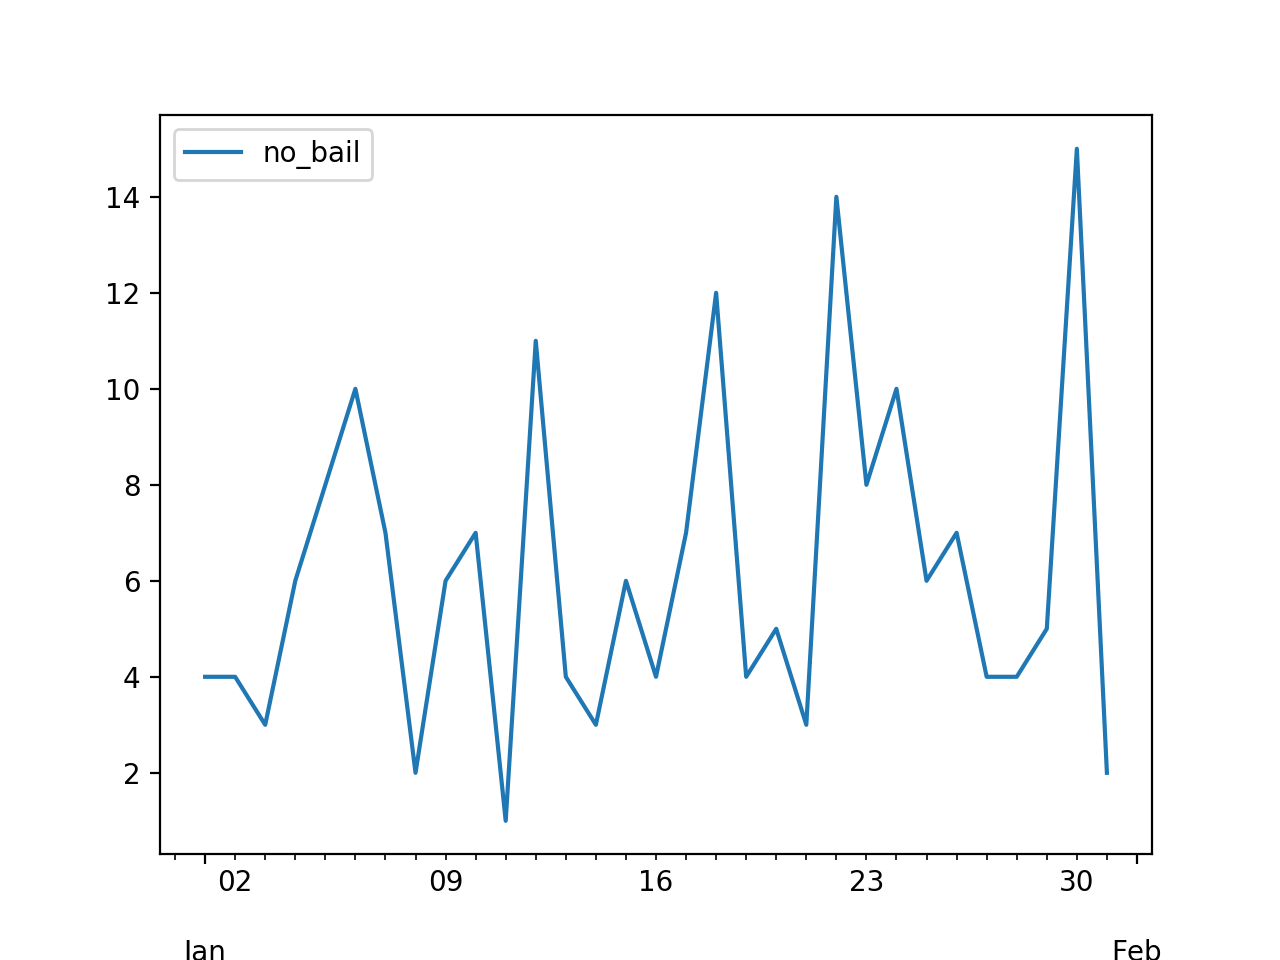

In [33]:
data_january.plot(x='date', y='no_bail')

What might account for the sharp dips? How could we find out?

### Adding titles and labels

While you can make plots suitable for publication using `matplotlib`, remember that we're doing exploratory visualization, so our goal is to gain insights about the data rather than make our visualization understandable to a wide audience, or be the most visually elegant charts. Still, we may want to share our charts with others in the newsroom, or save them without the context of our analysis notebook, so we should probably add a title for the chart as well as axis labels.

We can add a title using the `title` argument to the `DataFrame.plot` method.

<IPython.core.display.Javascript object>


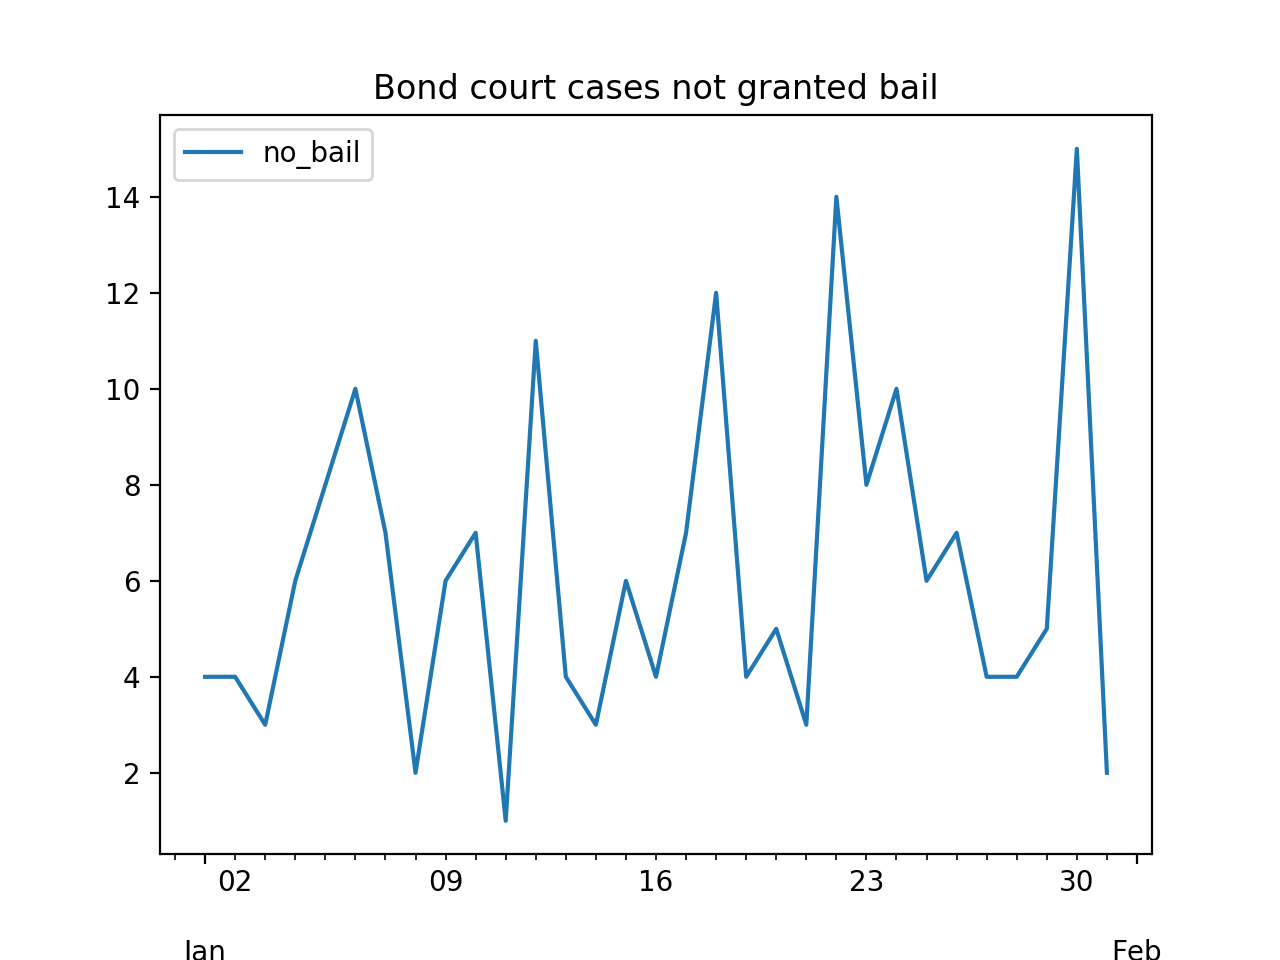

In [34]:
data_january.plot(x='date', y='no_bail', title="Bond court cases not granted bail")

You might have noticed that [`pandas.DataFrame.plot`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) returns an `AxesSubplot` object. You can read more about the Axes class' API [here](https://matplotlib.org/api/axes_api.html), but what's important is that this class has [`set_xlabel`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_xlabel.html#matplotlib.axes.Axes.set_xlabel) and [`set_ylabel`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_ylabel.html#matplotlib.axes.Axes.set_ylabel) methods that you can use to set the axis labels.

<IPython.core.display.Javascript object>


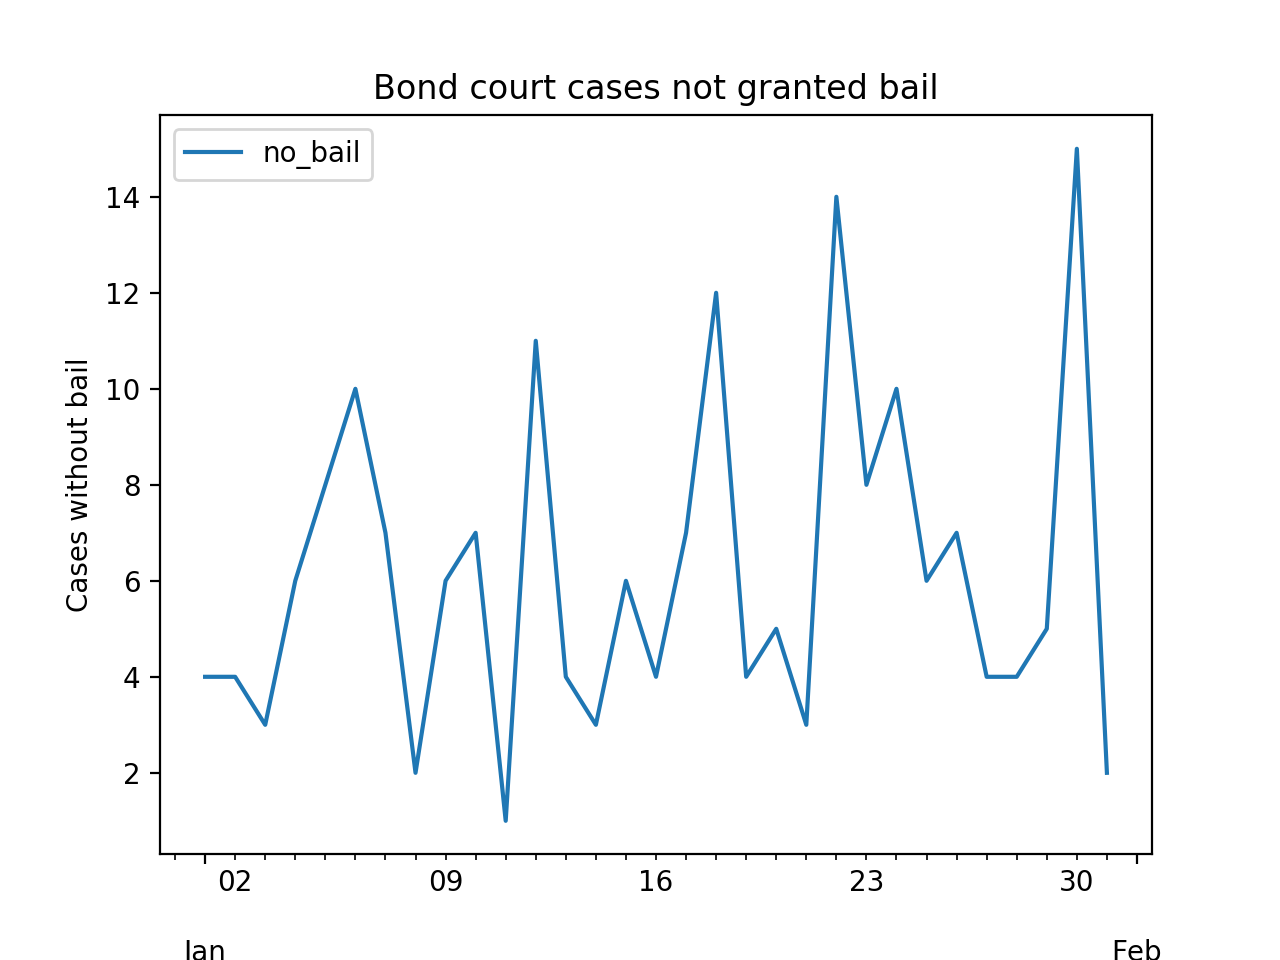

Text(0,0.5,'Cases without bail')

In [35]:
# Assign the `AxesSubplot` to a variable. It's conventional to use `ax`.
ax = data_january.plot(x='date', y='no_bail', title="Bond court cases not granted bail")

# Set the x and y axis labels.
ax.set_xlabel("Date")
ax.set_ylabel("Cases without bail")

### Adjusting figure size

At least on my screen, the x axis label gets cut out. We can specify the `figsize` argument to [`pandas.DataFrame.plot`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) to make the plot slightly larger. `figsize` is a tuple where the first item is width and the second item is height. The units for `figsize` are in inches, so you'll have to use your dots per inch (DPI) value, which is usually 96 for digital displays and a little arithmetic if you want to specify the values in pixels. I usually just play around with the values until I get dimensions that meet my needs.

<IPython.core.display.Javascript object>


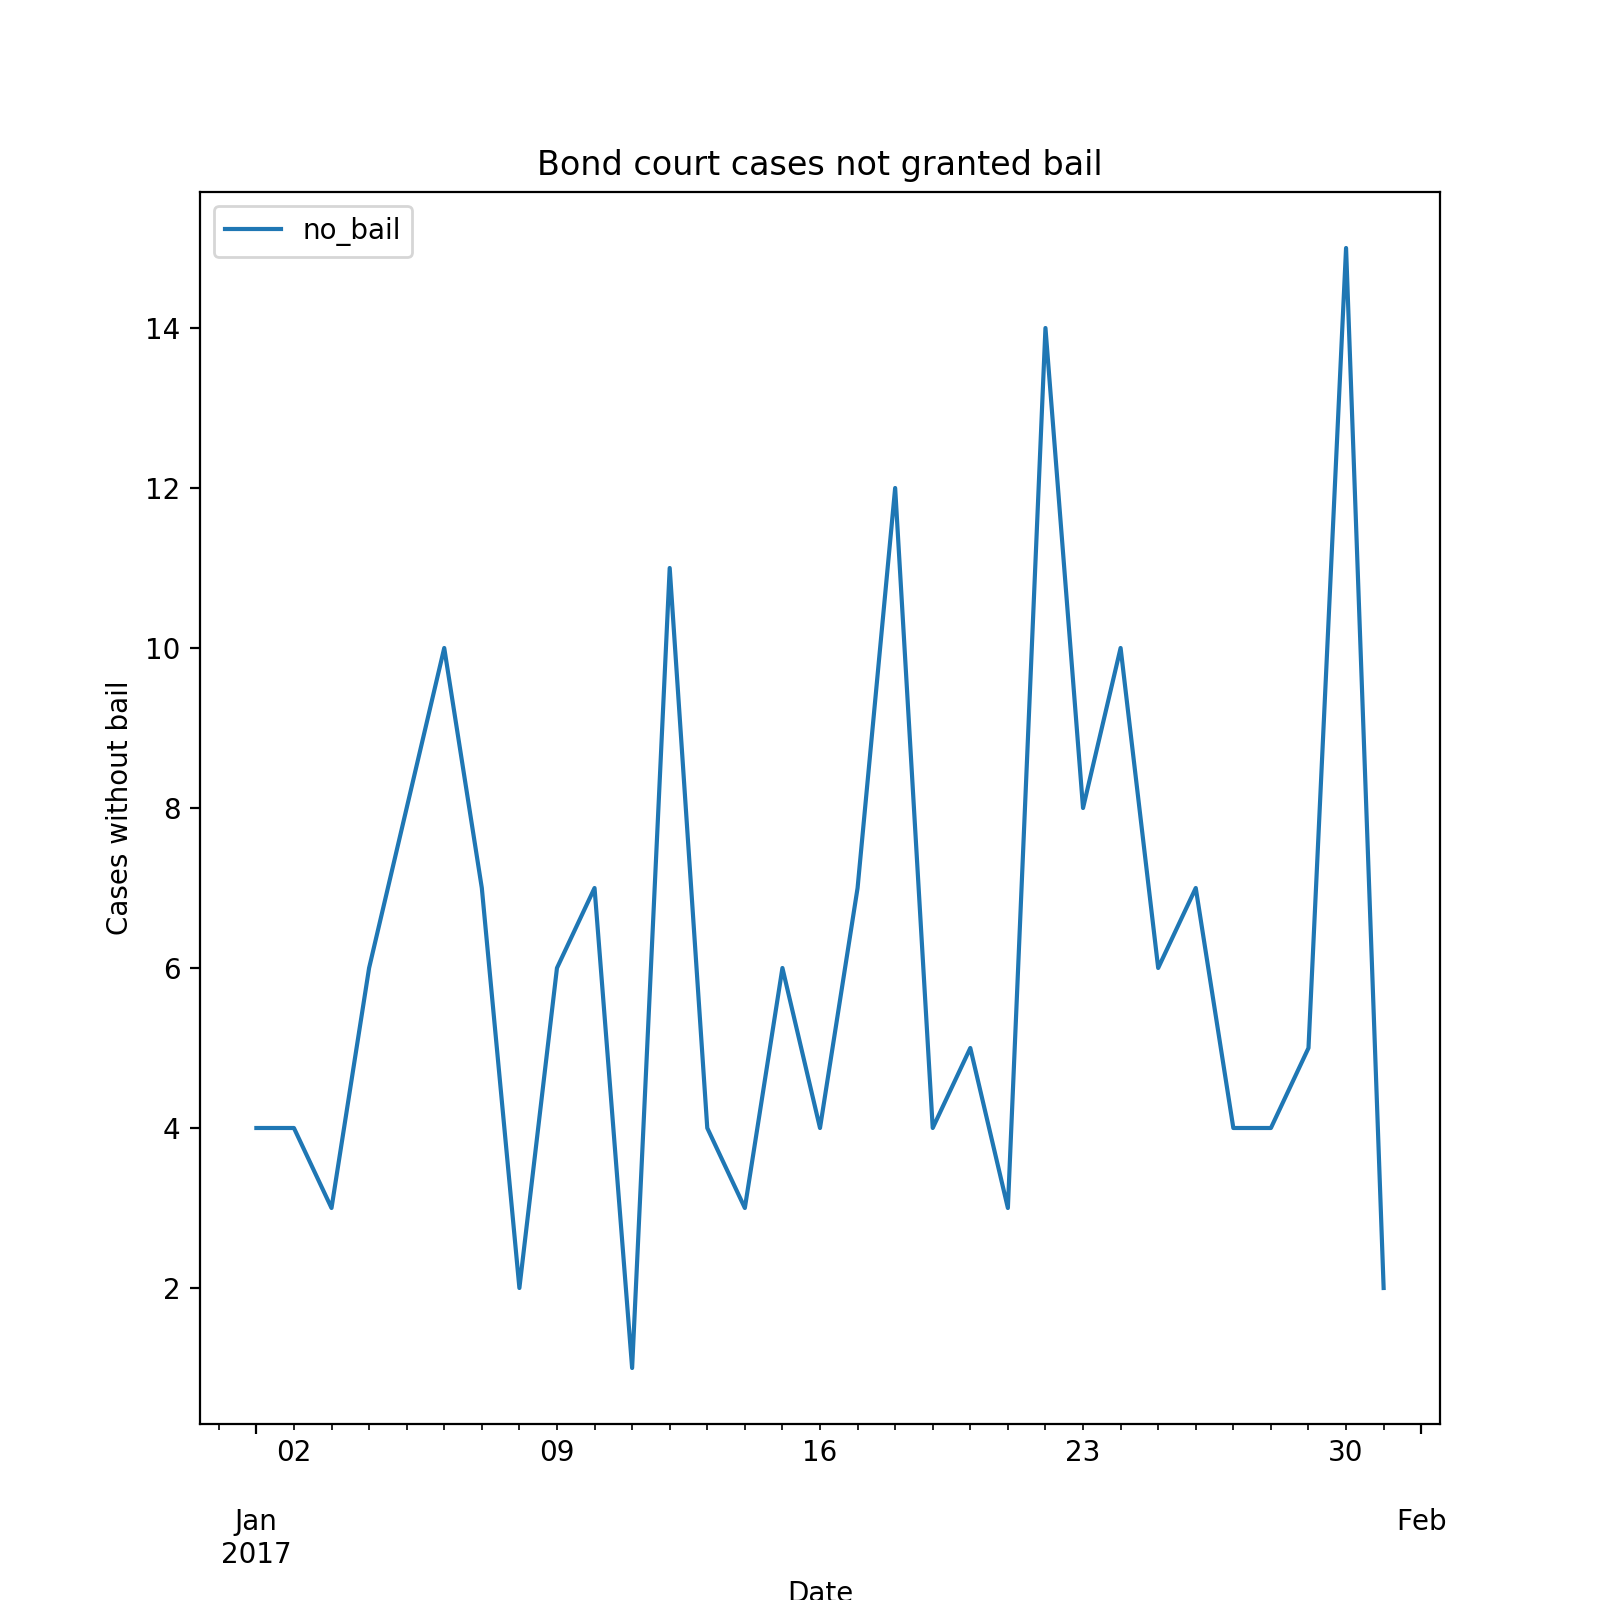

Text(0,0.5,'Cases without bail')

In [36]:
# Assign the `AxesSubplot` to a variable. It's conventional to use `ax`.
ax = data_january.plot(
    x='date',
    y='no_bail', 
    title="Bond court cases not granted bail",
    figsize=(8, 8)
)

# Set the x and y axis labels.
ax.set_xlabel("Date")
ax.set_ylabel("Cases without bail")

### Make labels fit using tight layout

You'll notice that adjusting the figure size, while making space for the date label, also changes the aspect ratio of the plot. This might not be desireable.  There's another way to make sure our labels don't get cut off. We can use the [tight layout](https://matplotlib.org/users/tight_layout_guide.html) feature of matplotlib's [`pyplot`](https://matplotlib.org/users/pyplot_tutorial.html) interface. `pyplot` provides a set of command style functions for plotting.

<IPython.core.display.Javascript object>


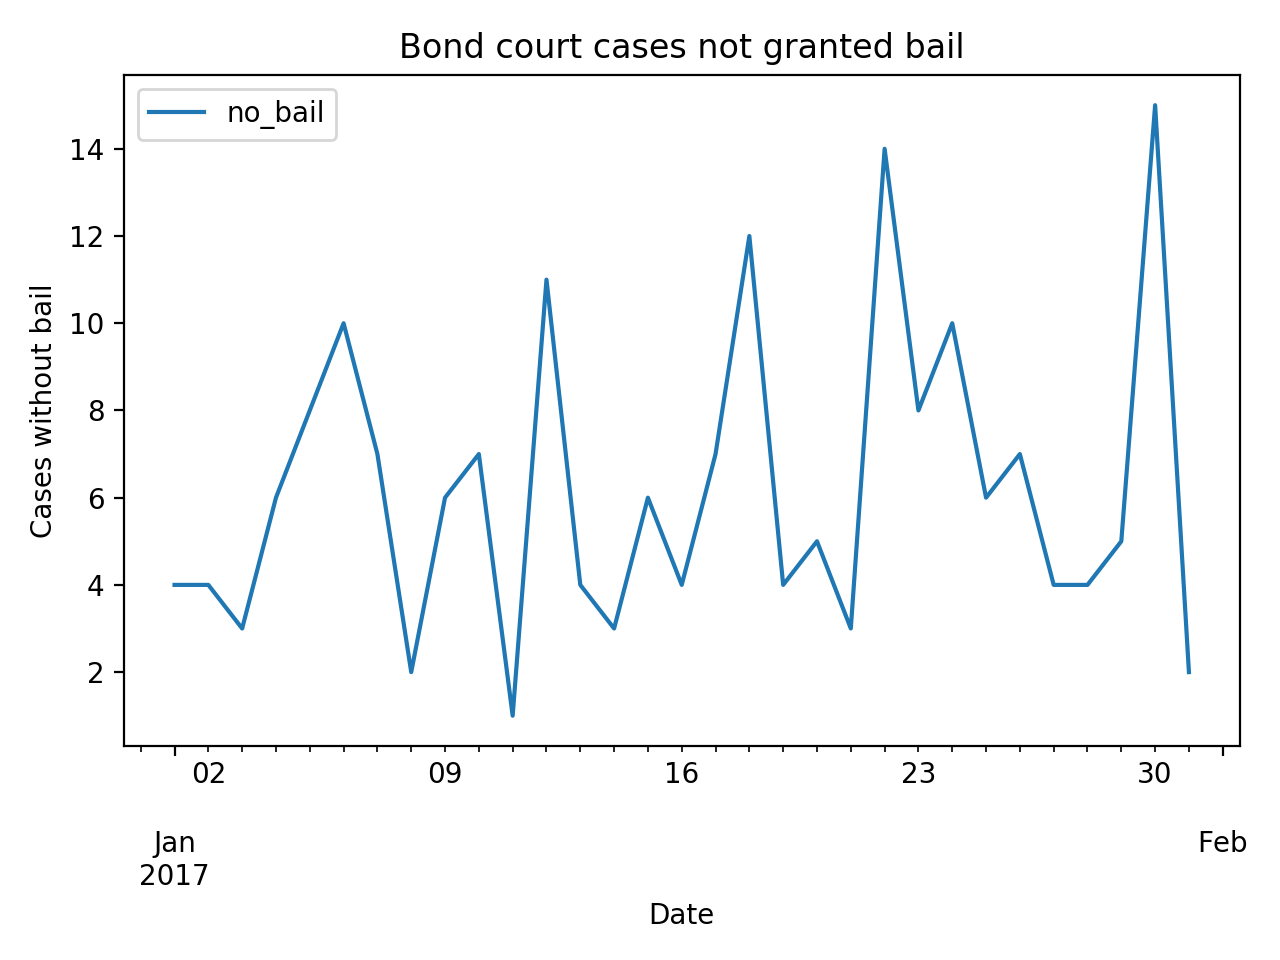

In [37]:
# This is how we import pyplot. `plt` is the conventional name
import matplotlib.pyplot as plt

# Assign the `AxesSubplot` to a variable. It's conventional to use `ax`.
ax = data_january.plot(x='date', y='no_bail', title="Bond court cases not granted bail")

# Set the x and y axis labels.
ax.set_xlabel("Date")
ax.set_ylabel("Cases without bail")

# Now, call `tight_layout` to make our labels fit
plt.tight_layout()

### Identify common cases using a histogram

When looking at even a moderately large dataset it can be difficult to know whether a particular value is particularly high or low. A histogram is one way to get a sense of the frequency of different values of a variable.

<IPython.core.display.Javascript object>


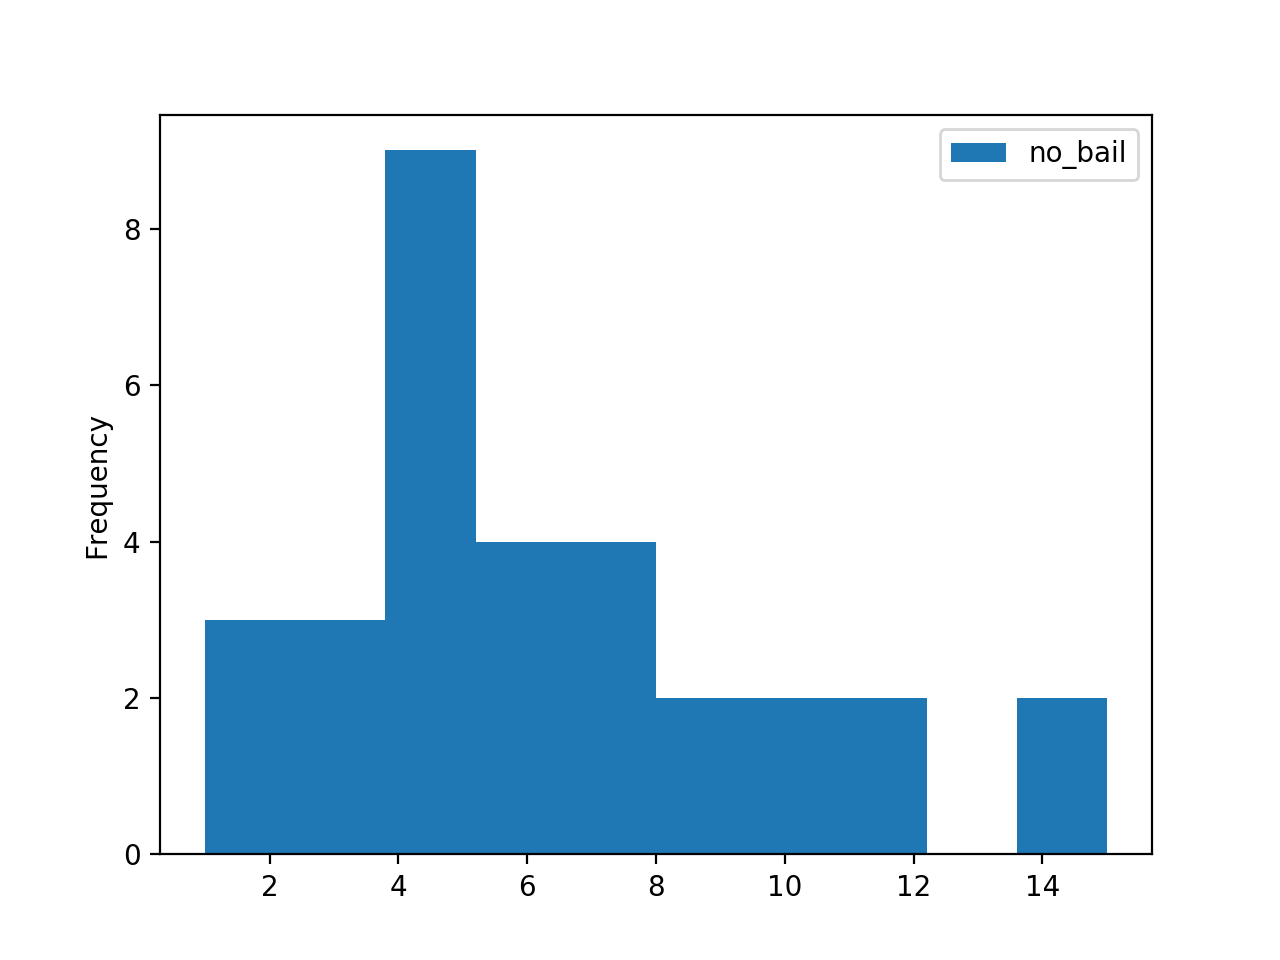

In [38]:
data_january.plot(kind='hist', y='no_bail')

### Identify centrality, quartiles and outliers with a boxplot

<IPython.core.display.Javascript object>


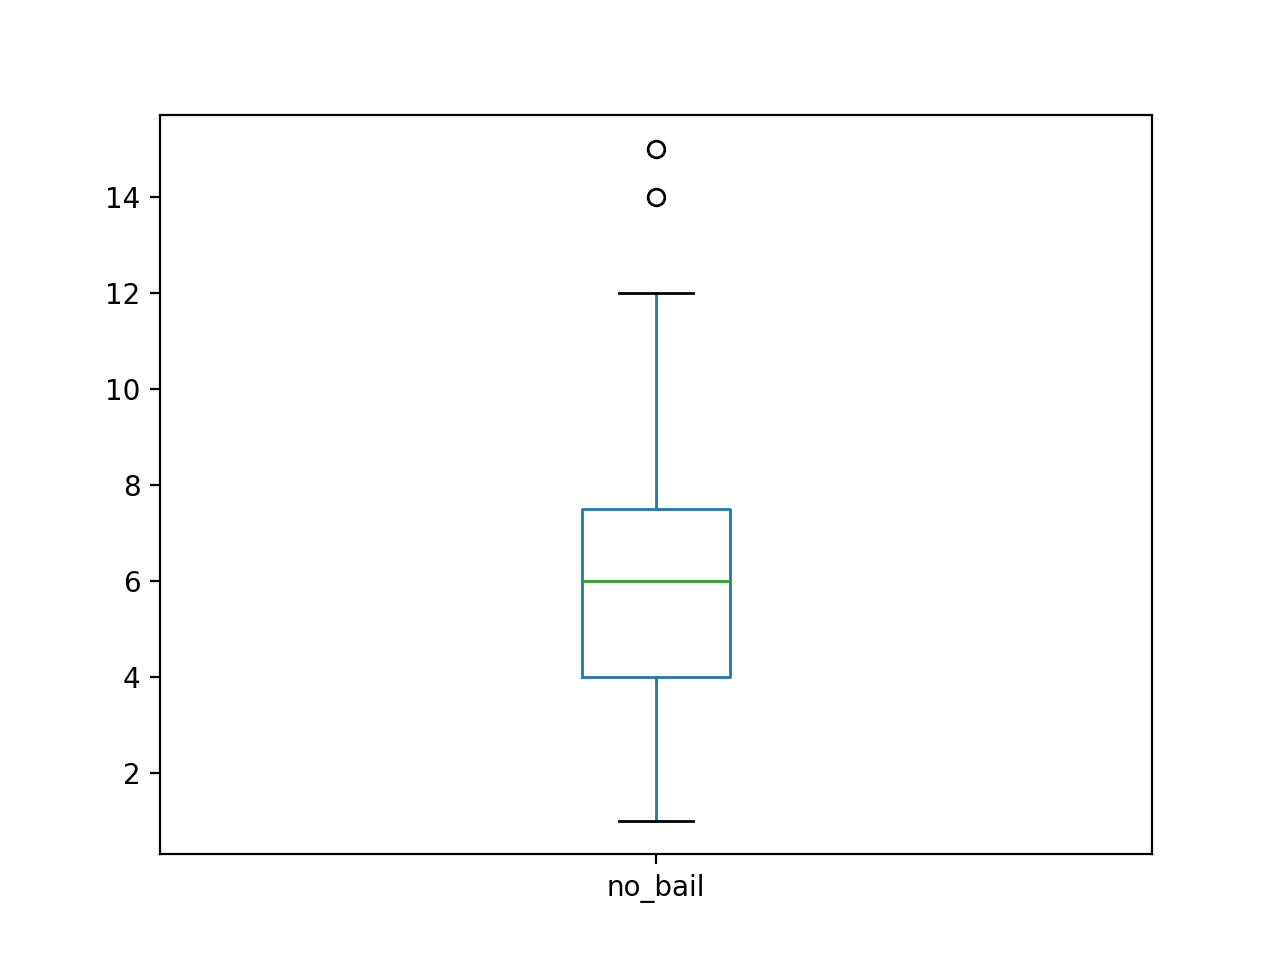

In [39]:
data_january.plot(kind='box', y='no_bail')

### Look for correlations using a scatterplot

<IPython.core.display.Javascript object>


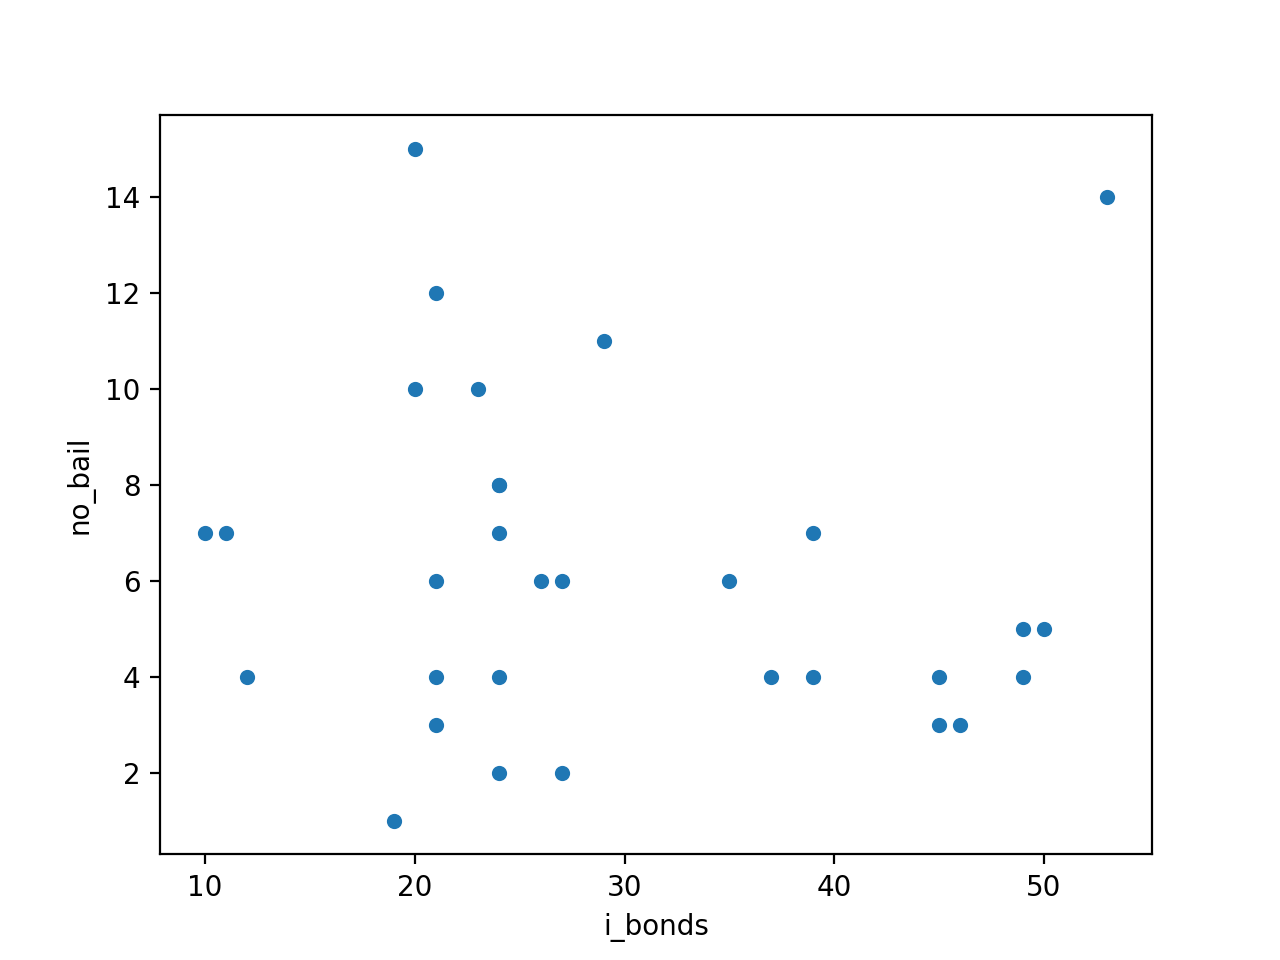

In [40]:
data_january.plot(kind='scatter', x='i_bonds', y='no_bail')

### Compare trends in multiple variables by plotting many lines

Calling `DataFrame.plot` without specifying a `y` argument will plot a line for each variable.

<IPython.core.display.Javascript object>


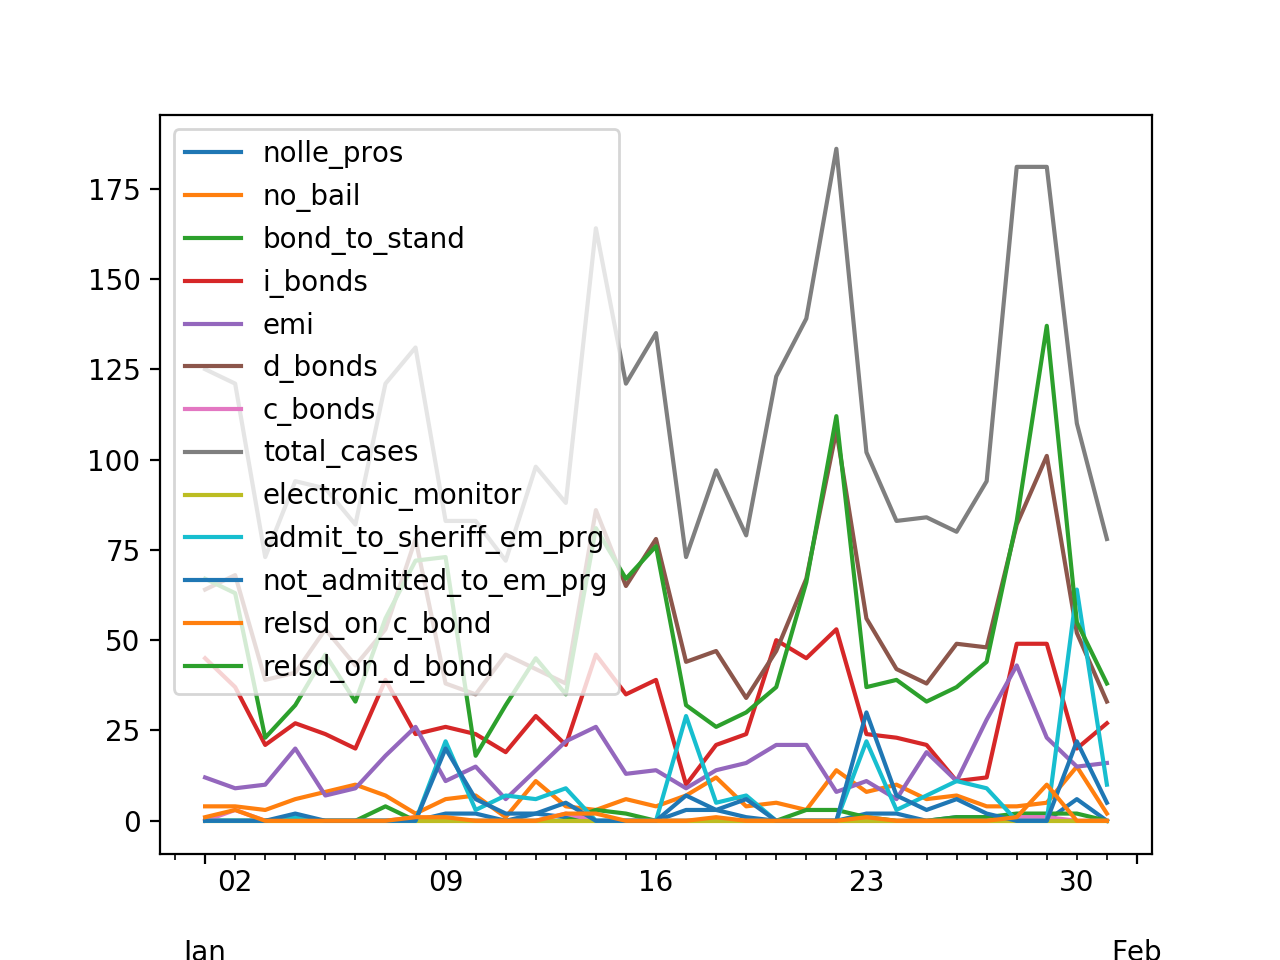

In [41]:
data_january.plot(kind='line', x='date')

### You try it: plot a subset of variables

There is a lot going on here. Let's narrow our focus a little. Can you take a slice of our `DataFrame` (`data-anuary`) to only plot lines for the number of I bonds, D bonds and C bonds?

<IPython.core.display.Javascript object>


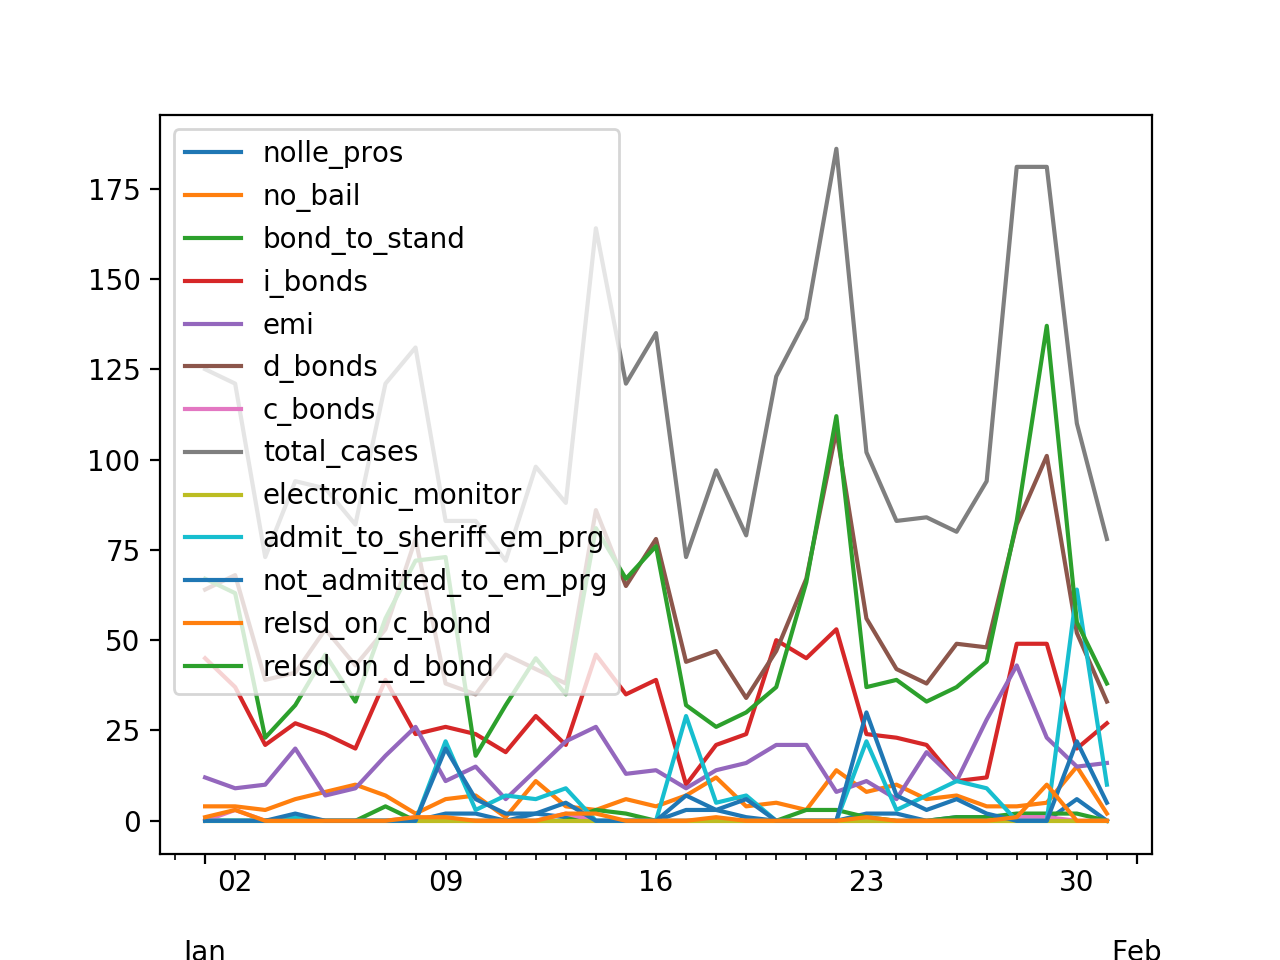

In [42]:
# EDIT THIS: Update the line below to only show lines for I bonds, D bonds and C bonds.
data_january.plot(kind='line', x='date')

Scroll down to see the solution.

⬇️


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;


<IPython.core.display.Javascript object>


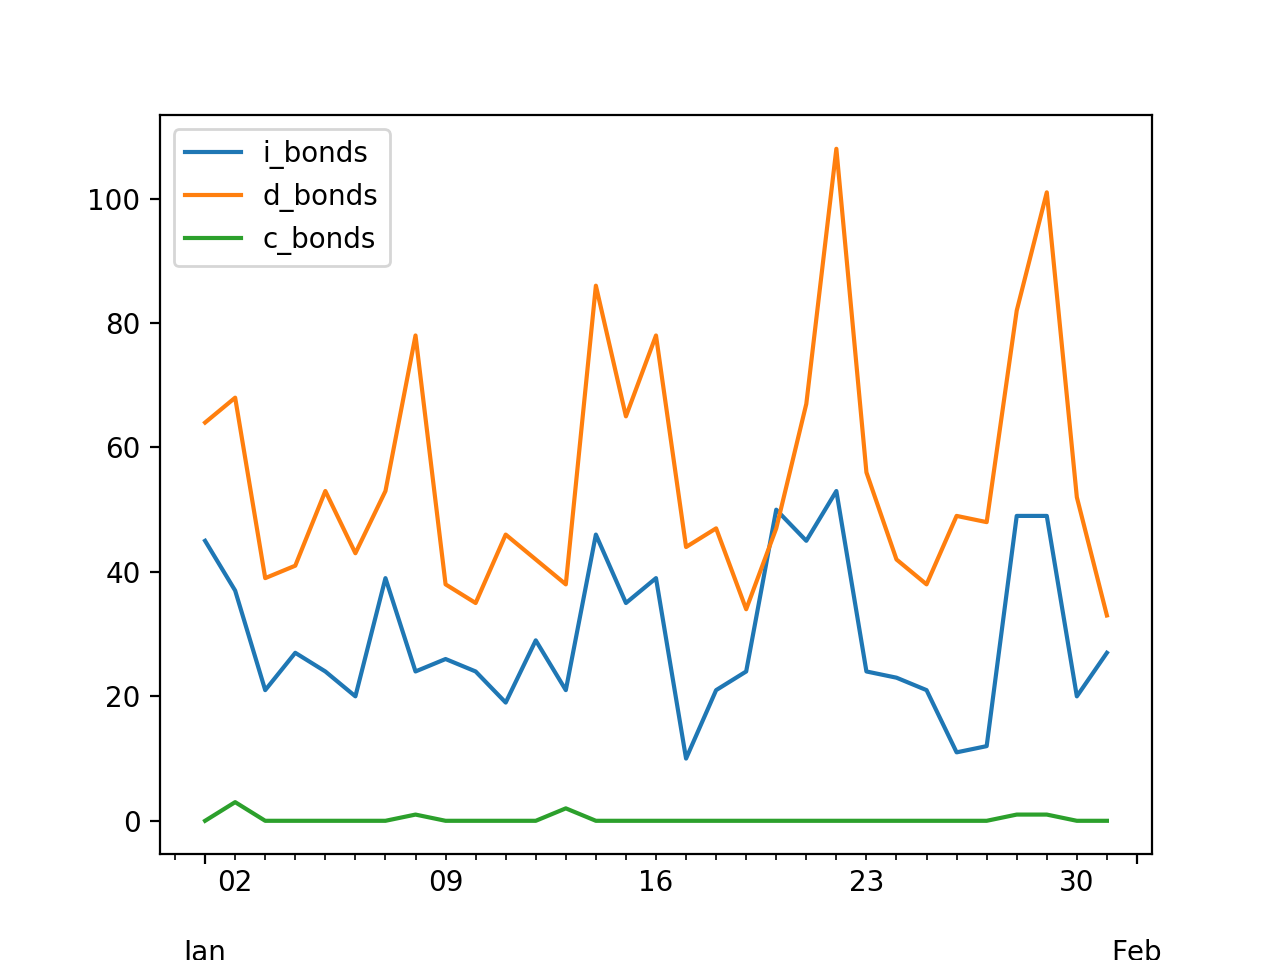

In [43]:
data_january[['date', 'i_bonds', 'd_bonds', 'c_bonds']].plot(kind='line', x='date')

### Subplots are another way to de-clutter plotting many variables

Specifying `True` for the `sublots` argument to `DataFrame.plot` is one way to plot each line its own space.

<IPython.core.display.Javascript object>


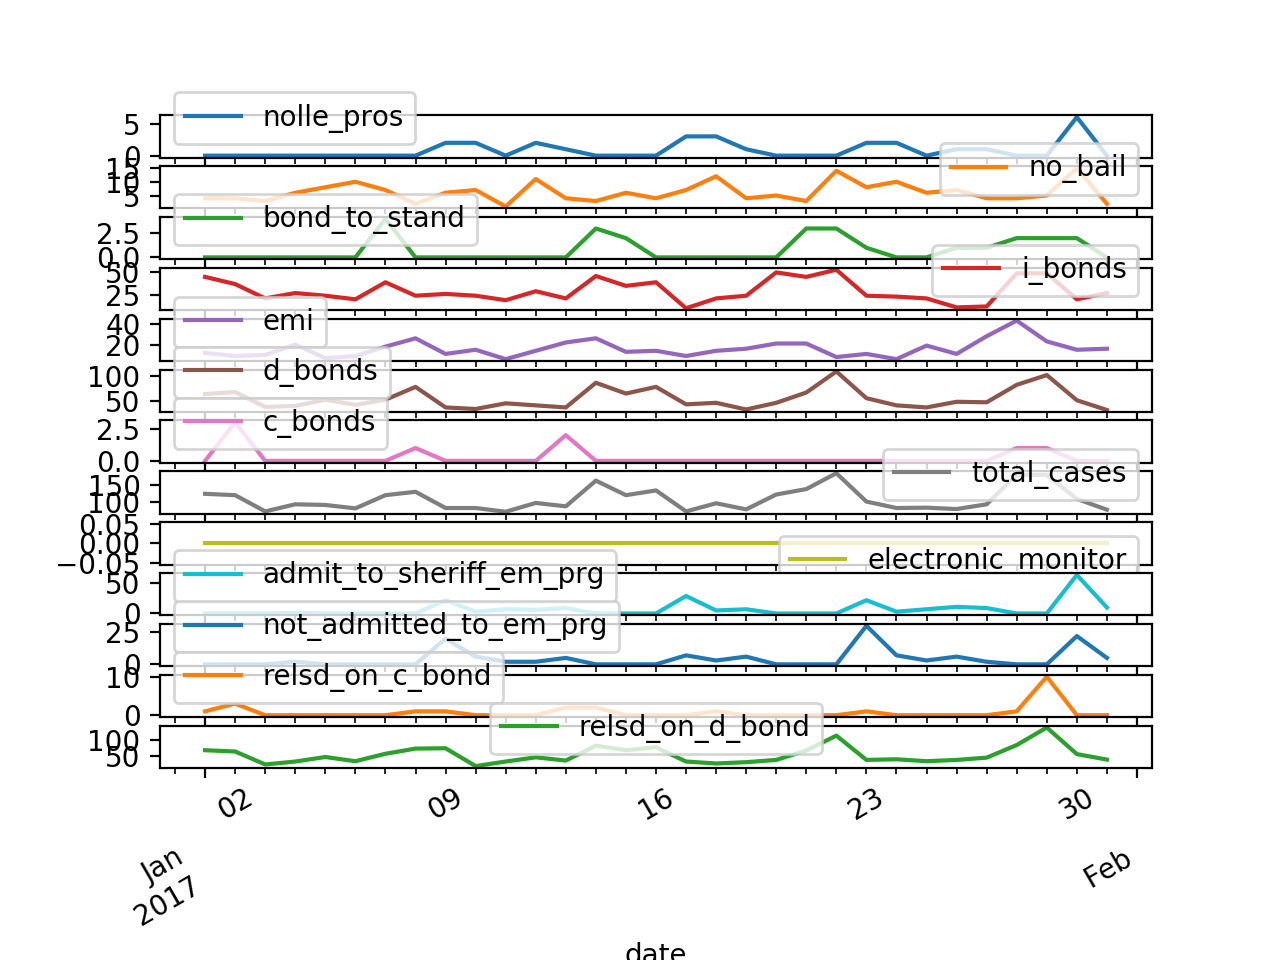

array([<matplotlib.axes._subplots.AxesSubplot object at 0x113aecf98>,
      dtype=object)

In [44]:
data_january.plot(kind='line', x='date', subplots=True)

That's still pretty cluttered. We can manually define a grid of subplots and plot variables in each grid cell.

<IPython.core.display.Javascript object>


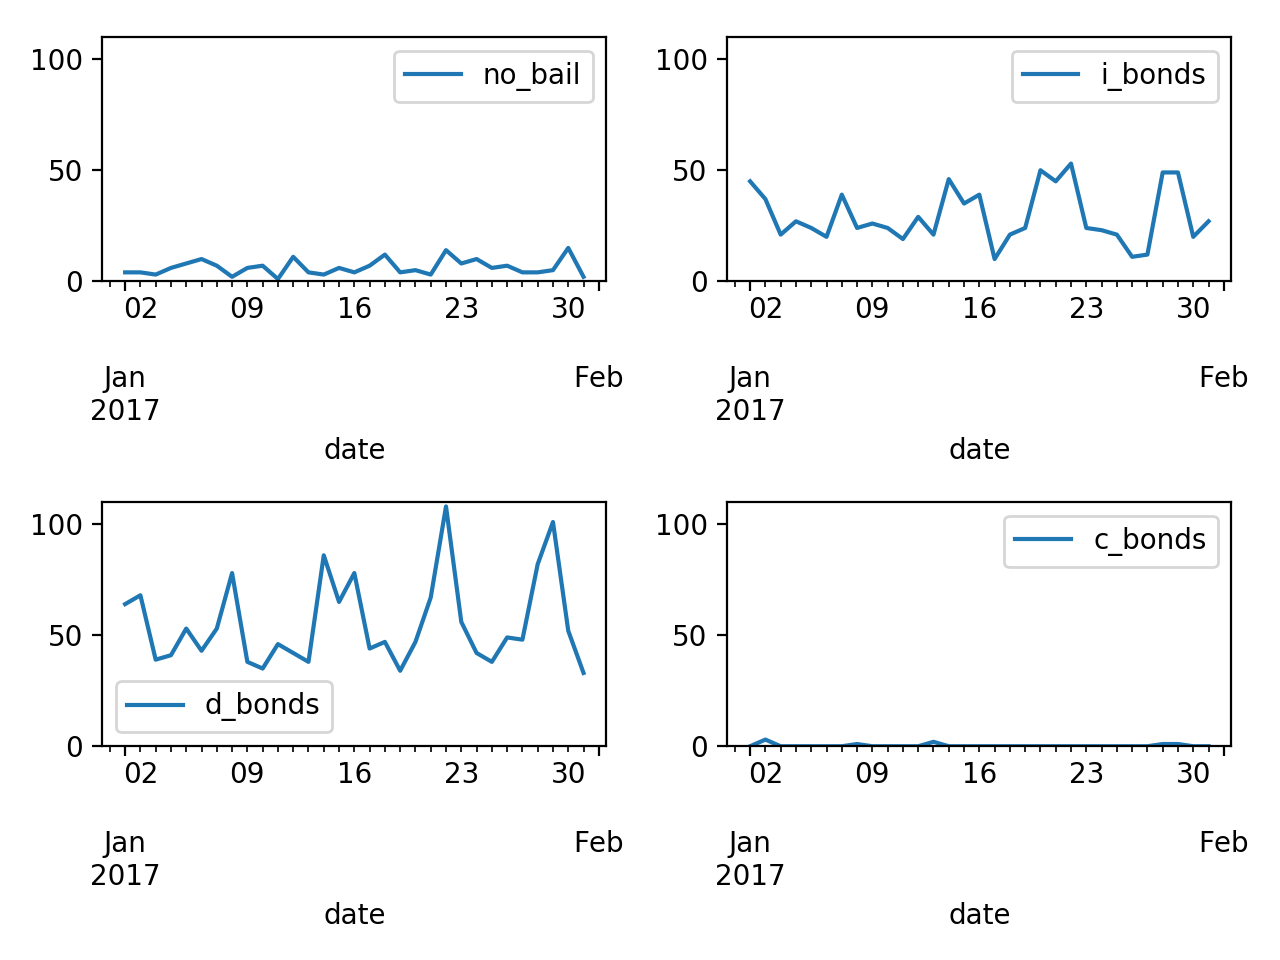

In [45]:
import matplotlib.pyplot as plt

# We're going to have a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2)

# Calculate the maximum across all our columns.
# We do this so we can have the same y axis limits for all subplots.
ymax = round(data_january[['no_bail', 'i_bonds', 'd_bonds', 'c_bonds']].max().max(), -1)
ylim = (0, ymax)

# Use the `ax` argument to specify which subplot we want to use for
# plotting the line chart of each variable.
data_january.plot(kind='line', x='date', y='no_bail', ax=axes[0, 0], ylim=ylim)
data_january.plot(kind='line', x='date', y='i_bonds', ax=axes[0, 1], ylim=ylim)
data_january.plot(kind='line', x='date', y='d_bonds', ax=axes[1, 0], ylim=ylim)
data_january.plot(kind='line', x='date', y='c_bonds', ax=axes[1, 1], ylim=ylim)

plt.tight_layout()


### You try it: plot additional variables

Update the code below to also draw line charts for the `total_cases` and `electronic_monitor` variables.

<IPython.core.display.Javascript object>


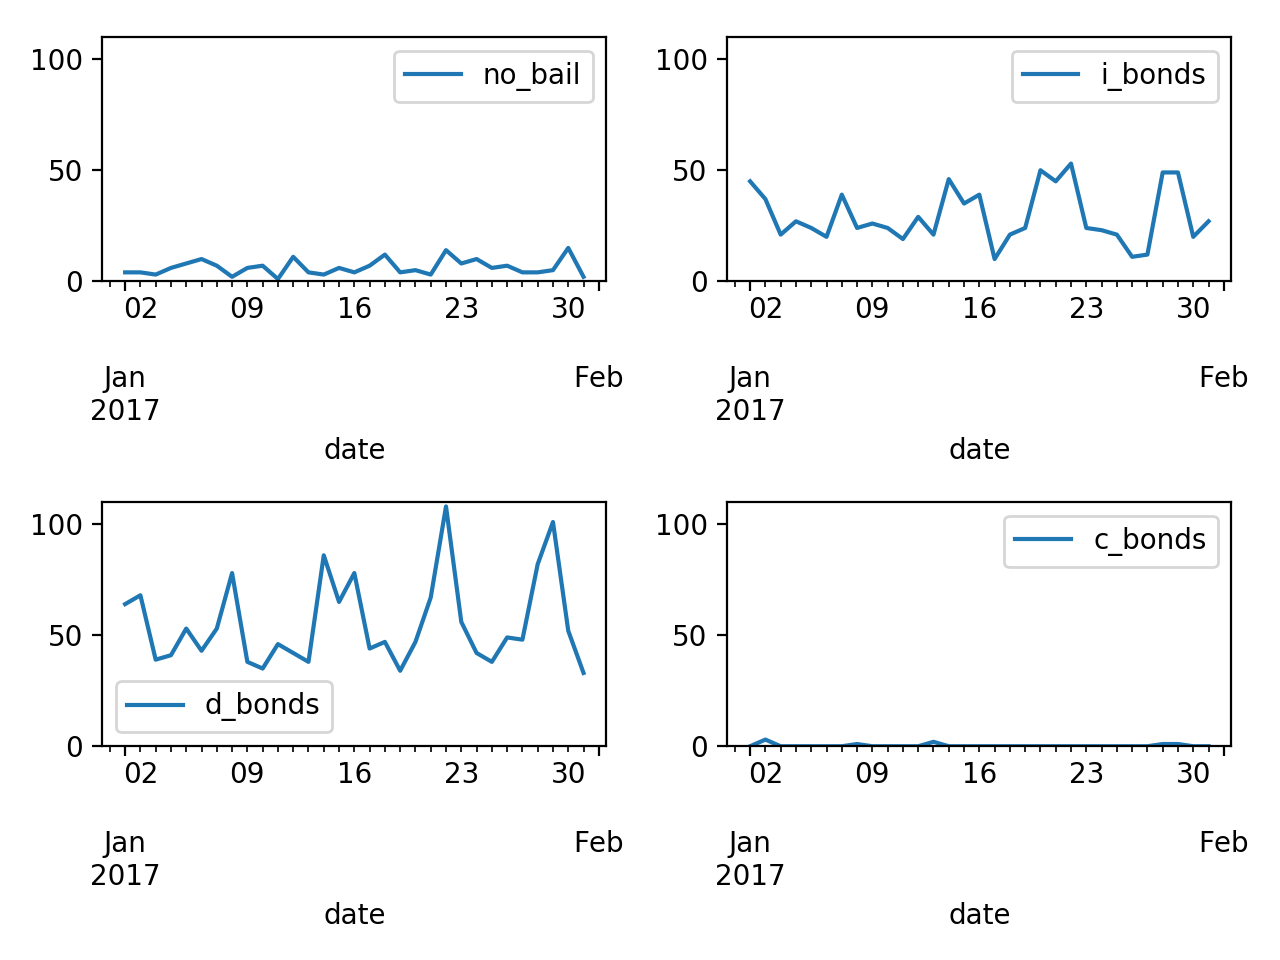

In [46]:
# EDIT THIS: Edit the line below to accomodate the two additional variables.
fig, axes = plt.subplots(nrows=2, ncols=2)

# Calculate the maximum across all our columns.
# We do this so we can have the same y axis limits for all subplots.
# EDIT THIS: Edit the line below to include the new variables.
ymax = round(data_january[['no_bail', 'i_bonds', 'd_bonds', 'c_bonds']].max().max(), -1)
ylim = (0, ymax)

# Use the `ax` argument to specify which subplot we want to use for
# plotting the line chart of each variable.
data_january.plot(kind='line', x='date', y='no_bail', ax=axes[0, 0], ylim=ylim)
data_january.plot(kind='line', x='date', y='i_bonds', ax=axes[0, 1], ylim=ylim)
data_january.plot(kind='line', x='date', y='d_bonds', ax=axes[1, 0], ylim=ylim)
data_january.plot(kind='line', x='date', y='c_bonds', ax=axes[1, 1], ylim=ylim)
# EDIT THIS: Add lines below to plot the additional variables.

plt.tight_layout()


Scroll down to see the solution.

⬇️


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;


<IPython.core.display.Javascript object>


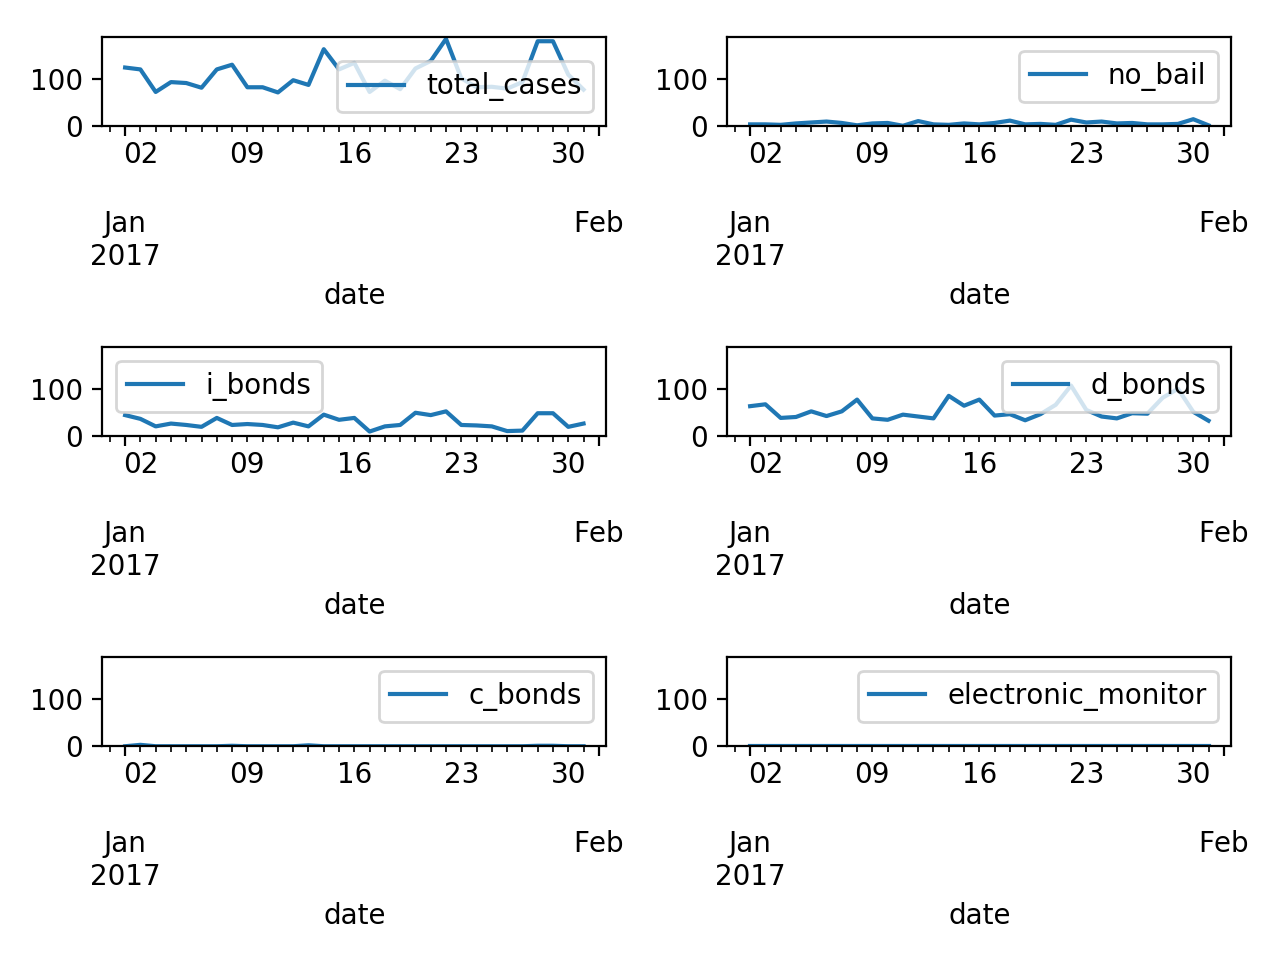

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=2)

# Calculate the maximum across all our columns.
# We do this so we can have the same y axis limits for all subplots.
ymax = round(data_january[['no_bail', 'i_bonds', 'd_bonds', 'c_bonds', 'total_cases', 'electronic_monitor']].max().max(), -1)
ylim = (0, ymax)

# Use the `ax` argument to specify which subplot we want to use for
# plotting the line chart of each variable.
data_january.plot(kind='line', x='date', y='total_cases', ax=axes[0, 0], ylim=ylim)
data_january.plot(kind='line', x='date', y='no_bail', ax=axes[0, 1], ylim=ylim)
data_january.plot(kind='line', x='date', y='i_bonds', ax=axes[1, 0], ylim=ylim)
data_january.plot(kind='line', x='date', y='d_bonds', ax=axes[1, 1], ylim=ylim)
data_january.plot(kind='line', x='date', y='c_bonds', ax=axes[2, 0], ylim=ylim)
data_january.plot(kind='line', x='date', y='electronic_monitor', ax=axes[2, 1], ylim=ylim)

plt.tight_layout()


### Next steps

Read the [visualization](http://pandas.pydata.org/pandas-docs/stable/visualization.html) section of the pandas documentation. It covers a lot of what we saw here in greater depth.

[Python Plotting With Matplotlib](https://realpython.com/blog/python/python-matplotlib-guide/) is a really great resource for understanding some of the design of the Matplotlib library and for orienting you around the model of plot elements. It's a techncal guide, but I found it easier to understand than some of the Pandas and Matplotlib documentation. 

Matplotlib is useful because it's integrated with Pandas, is widely used and doesn't require installing other dependencies. However, I find it's interface cumbersome. You might want to try out some other plotting libraries.

[Seaborne](https://seaborn.pydata.org/) is based on matplotlib, but tries to make common exploratory plots easier to create.

Matplotlib's `pyplot` interface is modeled after that of MATLAB. The popular [ggplot2](http://ggplot2.org/) package for R is based on the concept of a [grammar of graphics](http://vita.had.co.nz/papers/layered-grammar.pdf). This might be a clearer way to think about plotting. There is a Python library called [ggplot](http://ggplot.yhathq.com/) that is based on ggplot2 whose API is familiar to ggplot2 users.

